In [45]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

In [3]:
root_directory = r"C:\Users\Public\_Data\Old_HEJP_Data\Latest_Version"

jobs_table = pd.read_csv(root_directory + r"\Main_Data\Main_Table_01192020.csv")
print(len(jobs_table))
NSF_table = pd.read_csv(root_directory + r"\Faculty_Data\Faculty_Table_11222019.csv")
print(len(NSF_table))
# skill_table = pd.read_csv(root_directory + r"\Skills_Data\Skill_Table_06072019.csv")
# print(len(skill_table))

3957167
3957167


,index,count_x,count_y,growth
0,FS_Education,5999,7061,0.177030
1,Foreign languages and literature,2883,3806,0.320153
2,Other social sciences,2479,3723,0.501815
3,History,1906,2863,0.502099
4,Mathematics and statistics,3649,5532,0.516032
5,Political science and government,881,1357,0.540295
6,Business management and administration,7995,12512,0.564978
7,Letters,3470,5433,0.565706
8,Sociology,892,1433,0.606502
9,"Geosciences, atmospheric, and ocean sciences",641,1065,0.661466


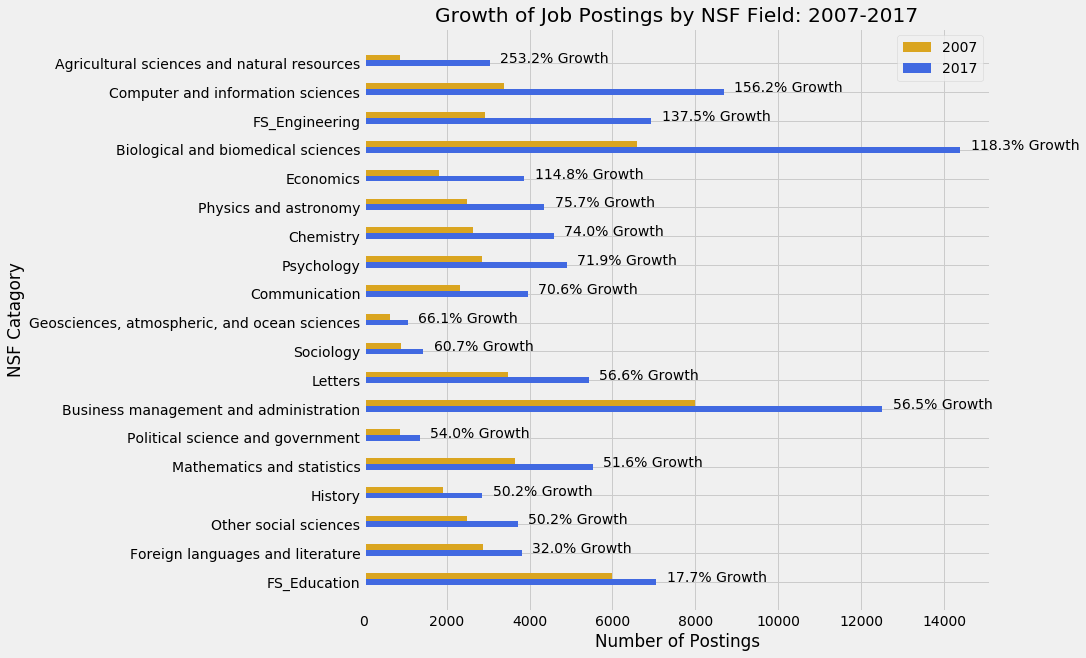

In [46]:
#########################################################
# Visualization (1)
# Growth of Job Postings by NSF Field of Study: 2007-2017
#########################################################

# Only the NSF field table is needed for this visualization.
# We will need to drop all observatiosn of non-faculty, Postdoc students, and Health
# sciences exclusive postings. Growth in Health sciences outstrips the growth of 
# other fields and therefore is given its own visualization to emphasize this fact.
# If included here, the scale of the graph is hard to read.

table = NSF_table[(NSF_table['Faculty']==1)|(NSF_table['Post-Doctoral']==0)]
table = table[((table['Health sciences'] != 1) | (table['Number of Detailed Fields of Study'] > 1))]

# (2)
def extract_fields(df, year, fields):
    # Isolate the years
    df = df[df['Year']==year]
    
    # Summation of an indicator attribute gives the number in that category
    field_totals = df[fields].sum()
    
    # Convert into a dataframe
    field_totals = pd.DataFrame(field_totals).reset_index()
    
    # Rename columns for clarity
    field_totals = field_totals.rename(columns={0:'count'})
    
    return field_totals
    
# Use this column list since it is not all columns of the NSF table that we are interested
# in presenting. For example we omit "Other humanities and arts" due to some uncertainty
# regarding how that category is populated.

NSF_fields = ['Agricultural sciences and natural resources', 'Biological and biomedical sciences',
               'Chemistry', 'Geosciences, atmospheric, and ocean sciences', 'Physics and astronomy',
               'Computer and information sciences', 'Mathematics and statistics', 'Psychology', 
               'Anthropology', 'Economics', 'Political science and government', 'Sociology', 
               'Other social sciences', 'FS_Engineering', 'FS_Education',
               'Foreign languages and literature', 'History', 'Letters', 
               'Business management and administration', 'Communication']

NSF_07 = extract_fields(table, 2007, NSF_fields)
NSF_17 = extract_fields(table, 2017, NSF_fields)

def get_growth(df1, df2):
    df = df1.merge(df2, on='index')
    
    df = df[df['count_y']>1000]
    
    df['growth'] = (df['count_y'] - df['count_x'])/df['count_x']
    
    df = df.sort_values(by='growth').reset_index(drop=True)
    
    return df
    
NSF_growth = get_growth(NSF_07, NSF_17)

display(NSF_growth)

def Graph_NSF(df, title):
    
    growth = df['growth'].values
    
    x1 = df['count_x'].values
    x2 = df['count_y'].values
    
    catagories = df['index'].values
    
    ind = np.arange(len(growth))

    for k in range(len(growth)):
       # print(growth[k], counts[k,:], ind[k])
        plt.annotate(s=str(round(growth[k]*100,1)) + '% Growth', xy=(x2[k]+250, ind[k]))
        
    width = 0.2
    
    plt.barh(ind + width, x1, width, label='2007', color='goldenrod')
    plt.barh(ind, x2, width, label='2017', color='royalblue')

    plt.yticks(ind, catagories)
    plt.ylabel('NSF Catagory')
    plt.xlabel('Number of Postings')
    plt.title(title)

    plt.legend(loc='upper right')
    
    fig = plt.gcf()
    fig.set_size_inches(10,10)
    
    plt.show()
    
    
Graph_NSF(NSF_growth, 'Growth of Job Postings by NSF Field: 2007-2017')

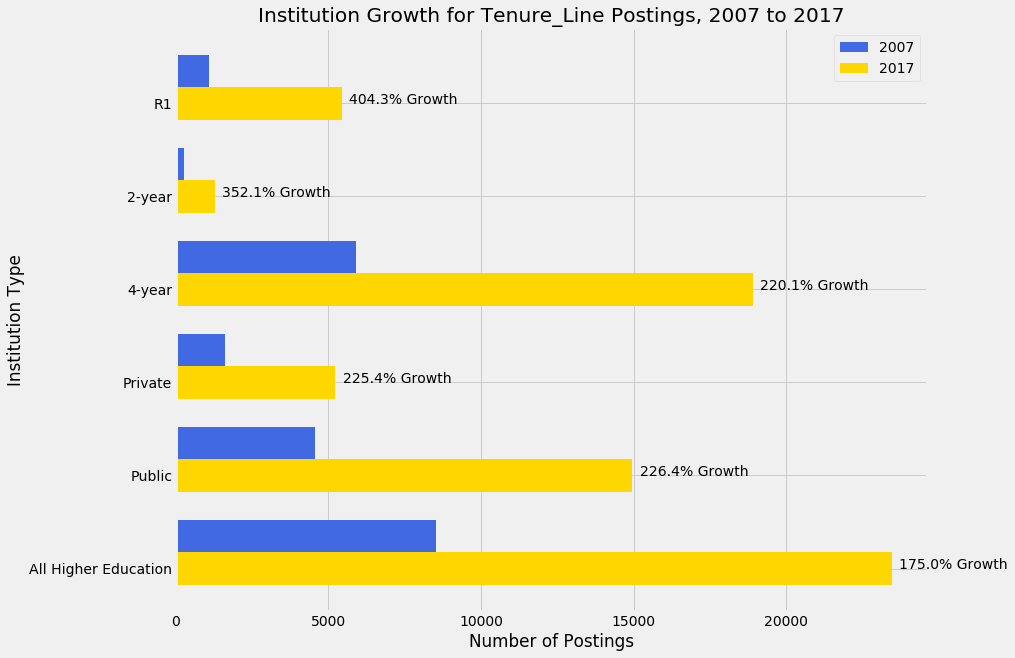

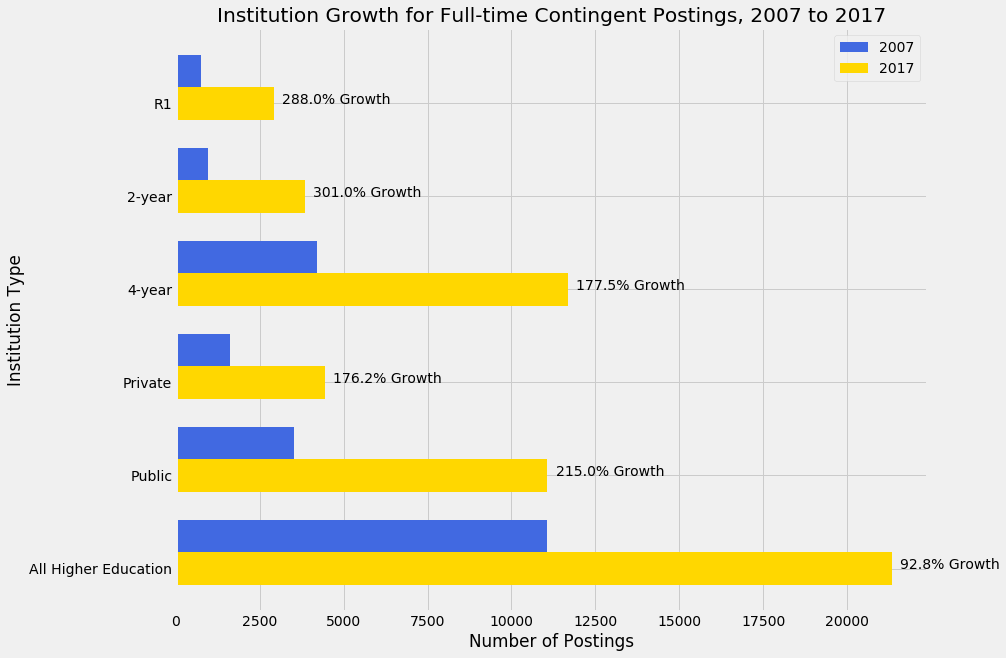

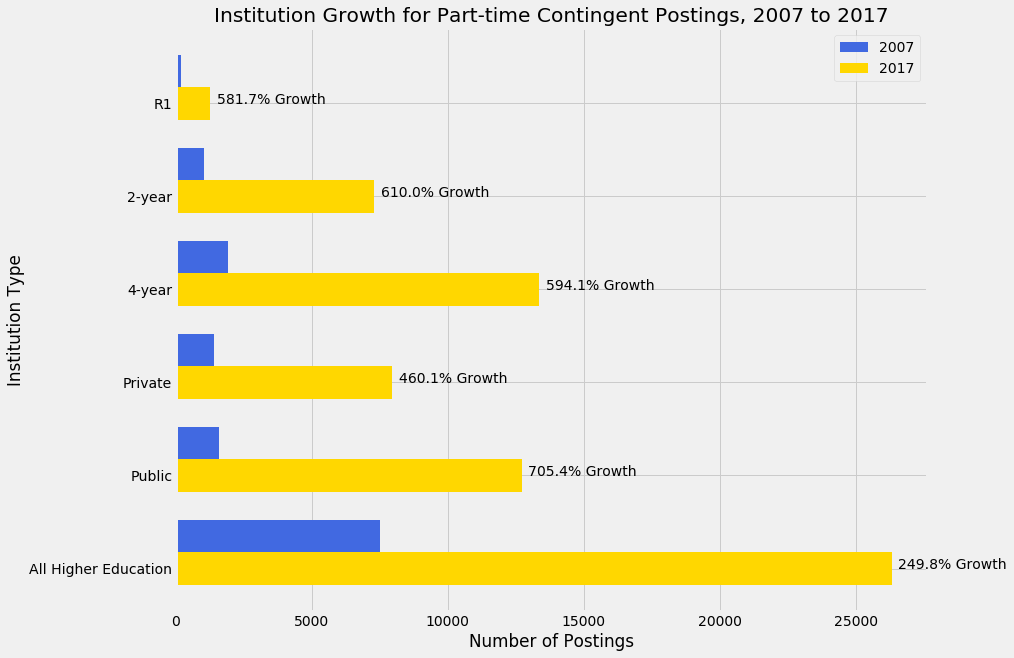

In [49]:
#################################################
# All Faculty Openings: 2010-1017
# Group by Employee type and by institution type
#################################################
# Method:

# (1) First choose the relevant data for the making of the graph. We want to divide the faculty
# listings into their type of faculty (Tenure-Line, Full-time Contingent, and Part-time Contingent)
# as well as divide the listings within those catagories by their IPEDS institution name, therefore,
# we will need the following columns: ['Job ID', 'Year', 'IPEDS Sector Name', 'Is Research 1 
# Institution?', 'Post-Doctoral', 'Faculty', 'Health sciences', 'Number of Detailed Fields of Study',
# 'Contingent', 'Full-time Contingent', 'Part-time Contingent', 'Tenured', 'Tenured_Track']. We will
# be using these to divide up our data, as well as get rid of certain edge case observations that
# confound the dataset.

# (2) Next we want to get rid of the edge case observations previously mentioned. To do this we will
# drop all listings for which the 'Post-Doctoral' dummy is equal to 1; this excludes the category of
# Post-docs that generally do not fit in with the other categories we are studying. Then we want to 
# exclude all jobs that are exclusively in the Healthcare industry or Health Sciences field. We must
# do it for both the faculty and non-faculty observations; non-faculty can be removed if their career
# area is 'Health Care including Nursing'. Faculty is slightly more complex since some faculty members
# are not specialized exclusivly in the Health sciences field. Therefore, we want to exclude all
# faculty listings that have only one 'Detailed Fields of Study' and are in the 'Health sciences' NSF 
# Field of Study ('Detailed Fields of Study' == 1 && 'Health sciences' == 1). You can also think of 
# this step as keeping all lsitings with 2 fields described, or those not in the Health sciences.
# Lastly we want to omit all years other than 2010 and year2 in order to compare the growth of the 
# job categories from both years, so drop all observations for which 'Year' is not equal to 2010 or 
# year2.

# (3) Next we do a series of manipulations designed to clarify the Tenure-Line and Contingent varaiables.
# These are necessary since some observations do not have mutual exclusivity between tenure varaibles
# and contingent varaibles. Therefore, we manually exclude them in favor of the tenure catagory. These
# manipulations can be described as follows: Construct tenure line as the union between Tenured and 
# Tenured_Track (sum the two and then limit the max value to 1), Replace contingent with 0 if 
# Tenure_Line is 1, replace Full-time and Part-time Contingent with 0 if Tenure_Line is 1.

# (4) Then we want to be able to decribe the type of institution that the listing comes from, there
# are some rules for these caregories: We want to divide them into All-Higher Education, R1 
# Universities, 4-Year Institutions, and 2-Year Institutions. R1 is easy since a dummy already exists
# for that category, for the others we will have to parse the string values in the 'IPEDS Sector Name'
# column. Here are the rules for that: Any observation that contains the substring '2-year' is a
# 2-Year Institution, any observation that contains the substrings '4-year' or 'Admin' are 4-Year 
# Institutions, and the rest are unknown values that we must omit from the anlayis. In this case new 
# dummy variables were created within the analysis for 2-year and 4-year. In the future these dummies
# will be included in the dataset in order to streamline this step and allow the data to be more
# understandable.

# (1) Merge the dataframes so that we have the target fields that we want (Job ID, Year, R1, Sector, and Post-Docs/Fauculty)

year1 = 2007
year2 = 2017

nsf = NSF_table[((NSF_table['Number of Detailed Fields of Study'] > 2) | (NSF_table['Health sciences'] != 1))]
nsf = nsf[(nsf['Post-Doctoral']!=1)&(nsf['Faculty']==1)]

full = jobs_table[['Job ID', '2-year', '4-year', 'Public', 'Private', 'R1']].merge(nsf, on='Job ID', how='inner')

full = full[(full['Year']==year1)|(full['Year']==year2)]

def get_sectorwise_counts(df, year, sectors):
    df = df[df['Year']==year]
    
    all_sectors = None
    for s in sectors:
        if s != 'All Higher Education':
            temp = df[df[s]==1]
        else:
            temp = df

        cat_sum = pd.DataFrame(temp[['Tenure_Line', 'Full-time Contingent', 'Part-time Contingent', 'Contingent']].sum())

        cat_sum = cat_sum.rename(columns={0:s})
        cat_sum = cat_sum.transpose()

        if all_sectors is None:
            all_sectors = cat_sum
        else:
            all_sectors = all_sectors.append(cat_sum)

    total = all_sectors['Full-time Contingent'] + all_sectors['Part-time Contingent']

    ftc_perc = all_sectors['Full-time Contingent']/total
    ptc_perc = all_sectors['Part-time Contingent']/total

    all_sectors['Full-time Contingent'] = round(all_sectors['Contingent'] * ftc_perc)
    all_sectors['Part-time Contingent'] = round(all_sectors['Contingent'] * ptc_perc)
    
    all_sectors = all_sectors.astype('int').reset_index()

    return(all_sectors)
    
sectors = ['All Higher Education', 'Public', 'Private', '4-year', '2-year', 'R1']    

sectors_07 = get_sectorwise_counts(full, year1, sectors)
sectors_17 = get_sectorwise_counts(full, year2, sectors)

def graph_sectors(df1, df2):
        
        ind = np.arange(len(df1))
        
        labels = df1['index']
        
        for s in ['Tenure_Line', 'Full-time Contingent', 'Part-time Contingent']:
            
            x1 = df1[s]
            x2 = df2[s]

            growth = round((x2-x1)/x1 * 100, 2)
            
            width = 0.35
            fig, ax = plt.subplots(figsize=(12, 10))
            
            ax.barh(ind+width, x1, width, label=year1, color='royalblue')
            ax.barh(ind, x2, width, label=year2, color='gold')
            

            plt.yticks(ind, labels)
            plt.ylabel('Institution Type')
            plt.xlabel('Number of Postings')
            plt.title(f'Institution Growth for {s} Postings, {year1} to {year2}')

            for k in range(len(labels)):
                plt.annotate(s=str(round(growth[k],1)) + '% Growth', xy=(x2[k]+250, ind[k]))

            plt.legend(loc='upper right')

            plt.show()

graph_sectors(sectors_07, sectors_17)

28005

In [31]:
jobs_table.columns

Index(['Job ID', 'Year', 'Job Title', 'Occupation', 'Career Area',
       'Minimum EDU Requirements', 'Maximum EDU Requirements',
       'Minimum Experience Requirements', 'Annual Salary',
       'Metropolitan Statistical Area', 'State', 'BEA_zone',
       'IPEDS Institution Name', 'IPEDS Sector Name', 'Institution_State',
       'Institution_BEA_zone', 'R1', '4-year', '2-year', 'Public', 'Private'],
      dtype='object')

In [32]:
NSF_table.columns

Index(['Job ID', 'Year', 'Diversity and Inclusion', 'Post-Doctoral', 'Faculty',
       'Agricultural sciences and natural resources',
       'Biological and biomedical sciences', 'Health sciences', 'Chemistry',
       'Geosciences, atmospheric, and ocean sciences', 'Physics and astronomy',
       'Computer and information sciences', 'Mathematics and statistics',
       'Psychology', 'Anthropology', 'Economics',
       'Political science and government', 'Sociology',
       'Other social sciences',
       'Aerospace, aeronautical, and astronautical engineering',
       'Bioengineering and biomedical engineering', 'Chemical engineering',
       'Civil engineering',
       'Electrical, electronics, and communications engineering',
       'Industrial and manufacturing engineering',
       'Materials science engineering', 'Mechanical engineering',
       'Other engineering', 'Education administration', 'Education research',
       'Teacher education', 'Teaching fields', 'Other education',
 